<a href="https://colab.research.google.com/github/matteolimoncini/COVID-19-search-engine/blob/main/COVID_19_Search_Engine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# various import and install
%%capture
!pip install split-folders
!pip install clustimage


import tensorflow as tf
import tensorflow_hub as hub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import splitfolders
import os
import urllib.request
import IPython.display as display
import shutil
import pickle 
import time
import datetime

import seaborn as sns
from sklearn.metrics import confusion_matrix

from PIL import Image 
from random import randint
from scipy.spatial import distance
from tqdm import tqdm

from clustimage import Clustimage

from keras.models import Model
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from scipy.spatial import distance_matrix

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE



#sarscov2 ctscan dataset

In [ ]:
# setting up kaggle and download dataset

%%capture
kaggle_path = '.kaggle'
if not (os.path.exists(kaggle_path)):
  !mkdir ~/.kaggle
  !echo '{"username":"matteolimoncini","key":"c4df437bb6e9108ad29ae9744b503c89"}' > ~/.kaggle/kaggle.json
  !chmod 600 ~/.kaggle/kaggle.json


!kaggle datasets download -d plameneduardo/sarscov2-ctscan-dataset
!unzip sarscov2-ctscan-dataset.zip -d sarscov2-ctscan-dataset
!rm sarscov2-ctscan-dataset.zip

## Data preprocessing

In [ ]:
# check image size 
folder_images = "./sarscov2-ctscan-dataset"

size_images = dict()
for dirpath, _, filenames in os.walk(folder_images):
    for path_image in filenames:
        image = os.path.abspath(os.path.join(dirpath, path_image))
        with Image.open(image) as img:
            width, heigth = img.size
            size_images[path_image] = {'width': width, 'heigth': heigth}

sizes = []
for keys,values in size_images.items():
  sizes.append((values.get('width'),values.get('heigth')))


max_width = max(sizes,key=lambda item:item[0])[0]
min_width = min(sizes,key=lambda item:item[0])[0]
max_heigth = (max(sizes,key=lambda item:item[1])[1])
min_heigth = (min(sizes,key=lambda item:item[1])[1])
print ('max width images: '+str(max_width)+'\n'+'min width images: '+str(min_width))
print ('max heigth images: '+str(max_heigth)+'\n'+'min heigth images: '+str(min_heigth))

max width images: 534
min width images: 182
max heigth images: 416
min heigth images: 119


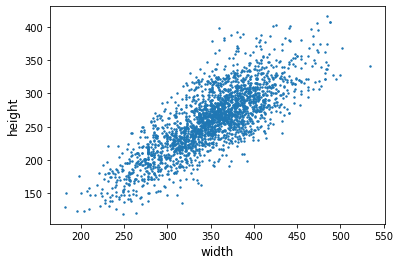

In [ ]:
# check visually image size
x = [i[0] for i in sizes]
y = [i[1] for i in sizes]
plt.scatter(x, y, s=2)
plt.xlabel('width', fontsize='large')
plt.ylabel('height', fontsize = 'large')
plt.show()

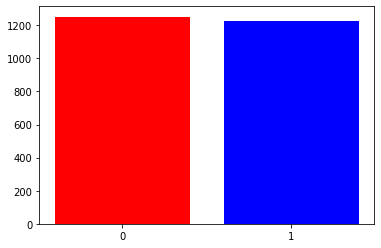

In [ ]:
# is the dataset balanced? 
covid = len(os.listdir('/content/sarscov2-ctscan-dataset/COVID'))
no_covid = len(os.listdir('/content/sarscov2-ctscan-dataset/non-COVID'))

plt.bar([0,1], [covid, no_covid], color=['red', 'blue'])
plt.xticks(np.arange(0, 2, 1))
plt.show()

## Classification

In [ ]:
# setup global parameter
TRAINING_DIR = '/content/splitted_img/train'
VALIDATION_DIR = '/content/splitted_img/val'
TEST_DIR = '/content/splitted_img/test'
IMG_SIZE = 256
BATCH_SIZE = 64
SEED = 123
AUTOTUNE = tf.data.AUTOTUNE
RANDOM_SEED = 10

In [ ]:
# folder splitting
splitfolders.ratio("./sarscov2-ctscan-dataset", output="splitted_img", seed=RANDOM_SEED, ratio=(.8, .1, .1), group_prefix=None)

Copying files: 2481 files [00:01, 2373.67 files/s]


In [ ]:
# creating train, validation and test sets applying image resizing
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(TRAINING_DIR,
                                                                      labels='inferred', label_mode='binary', color_mode = 'grayscale', 
                                                                      image_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE,
                                                                      seed = SEED,
                                                                      smart_resize = True)

val_dataset = tf.keras.preprocessing.image_dataset_from_directory(VALIDATION_DIR,
                                                                      labels='inferred', label_mode='binary', color_mode = 'grayscale',
                                                                      image_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE,
                                                                      seed = SEED,
                                                                      smart_resize = True)

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(TEST_DIR,
                                                                      labels='inferred', label_mode='binary', color_mode = 'grayscale',
                                                                      image_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE,
                                                                      seed = SEED,
                                                                      smart_resize = True)


Found 1984 files belonging to 2 classes.
Found 247 files belonging to 2 classes.
Found 250 files belonging to 2 classes.


In [ ]:
# pixel normalization 
def normalize_data(ds, shuffle = False):
    normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
    normalized_ds = ds.map(lambda x, y: (normalization_layer(x), y))
    normalized_ds = normalized_ds.cache()

    if shuffle:
      normalized_ds = normalized_ds.shuffle(2000, seed=RANDOM_SEED)
    
    normalized_ds = normalized_ds.prefetch(buffer_size=AUTOTUNE)
    return normalized_ds
  
train_ds = normalize_data(train_dataset, True)
val_ds = normalize_data(val_dataset, False)
test_ds = normalize_data(test_dataset)

### Classification using a Convolutional Neural Network (CNN)

In [ ]:
def cnn_class():
  model_cnn = tf.keras.models.Sequential([
                                          tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(IMG_SIZE,IMG_SIZE,1), padding='same'),
                                          tf.keras.layers.MaxPooling2D(2,2),
                                          tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same', strides=2),
                                          tf.keras.layers.MaxPooling2D(2,2),
                                          tf.keras.layers.Flatten(),
                                          tf.keras.layers.Dense(128, activation='relu'),
                                          tf.keras.layers.Dense(1, activation='sigmoid')
  ]
  )
  model_cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
  return model_cnn

In [ ]:
cnn = cnn_class()
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 16)      160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 128)               4

In [ ]:
#@markdown Code to display dynamically loss and accuracy curve

# Matplotlib config
plt.ioff()
plt.rc('image', cmap='gray_r')
plt.rc('grid', linewidth=1)
plt.rc('xtick', top=False, bottom=False, labelsize='large')
plt.rc('ytick', left=False, right=False, labelsize='large')
plt.rc('axes', facecolor='F8F8F8', titlesize="large", edgecolor='white')
plt.rc('text', color='a8151a')
plt.rc('figure', facecolor='F0F0F0', figsize=(14,9))

def plot_learning_rate(lr_func, epochs):
  xx = np.arange(epochs+1, dtype=np.float)
  y = [lr_decay(x) for x in xx]
  fig, ax = plt.subplots(figsize=(9, 6))
  ax.set_xlabel('epochs')
  ax.set_title('Learning rate\ndecays from {:0.3g} to {:0.3g}'.format(y[0], y[-2]))
  ax.minorticks_on()
  ax.grid(True, which='major', axis='both', linestyle='-', linewidth=1)
  ax.grid(True, which='minor', axis='both', linestyle=':', linewidth=0.5)
  ax.step(xx,y, linewidth=3, where='post')
  display.display(fig)

class PlotTraining(tf.keras.callbacks.Callback):
  def __init__(self, sample_rate=1, zoom=1):
    self.sample_rate = sample_rate
    self.step = 0
    self.zoom = zoom
    self.steps_per_epoch = len(train_dataset)

  def on_train_begin(self, logs={}):
    self.batch_history = {}
    self.batch_step = []
    self.epoch_history = {}
    self.epoch_step = []
    self.fig, self.axes = plt.subplots(1, 2, figsize=(16, 7))
    plt.ioff()

  def on_batch_end(self, batch, logs={}):
    if (batch % self.sample_rate) == 0:
      self.batch_step.append(self.step)
      for k,v in logs.items():
        # do not log "batch" and "size" metrics that do not change
        # do not log training accuracy "acc"
        if k=='batch' or k=='size':# or k=='acc':
          continue
        self.batch_history.setdefault(k, []).append(v)
    self.step += 1

  def on_epoch_end(self, epoch, logs={}):
    plt.close(self.fig)
    self.axes[0].cla()
    self.axes[1].cla()
      
    self.axes[0].set_ylim(0, 1.2/self.zoom)
    self.axes[1].set_ylim(1-1/self.zoom/2, 1+0.1/self.zoom/2)
    
    self.epoch_step.append(self.step)
    for k,v in logs.items():
      # only log validation metrics
      if not k.startswith('val_'):
        continue
      self.epoch_history.setdefault(k, []).append(v)

    display.clear_output(wait=True)
    
    for k,v in self.batch_history.items():
      self.axes[0 if k.endswith('loss') else 1].plot(np.array(self.batch_step) / self.steps_per_epoch, v, label=k)
      
    for k,v in self.epoch_history.items():
      self.axes[0 if k.endswith('loss') else 1].plot(np.array(self.epoch_step) / self.steps_per_epoch, v, label=k, linewidth=3)
      
    self.axes[0].legend(prop={'size':14})
    self.axes[1].legend(prop={'size':14})
    self.axes[0].set_xlabel('epochs',fontsize=14)
    self.axes[1].set_xlabel('epochs',fontsize=14)
    self.axes[0].minorticks_on()
    self.axes[0].grid(True, which='major', axis='both', linestyle='-', linewidth=1)
    self.axes[0].grid(True, which='minor', axis='both', linestyle=':', linewidth=0.5)
    self.axes[1].minorticks_on()
    self.axes[1].grid(True, which='major', axis='both', linestyle='-', linewidth=1)
    self.axes[1].grid(True, which='minor', axis='both', linestyle=':', linewidth=0.5)
    display.display(self.fig)

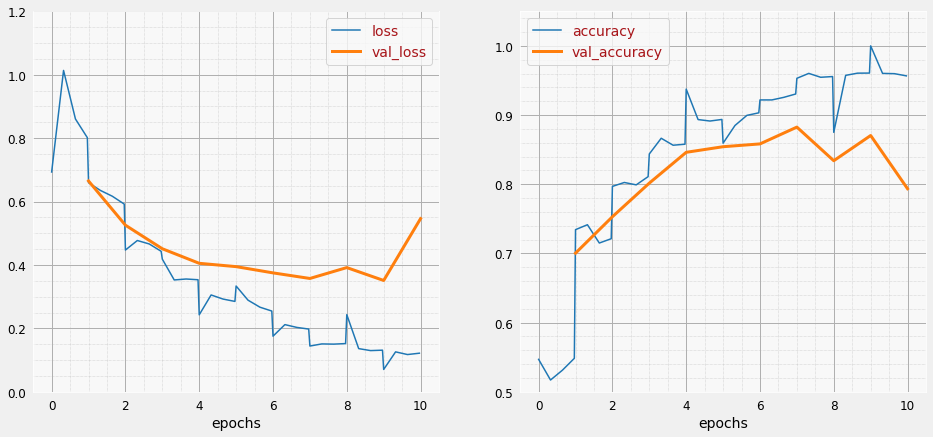

31/31 [==============================] - 2s 77ms/step - loss: 0.1217 - accuracy: 0.9567 - val_loss: 0.5462 - val_accuracy: 0.7935


In [ ]:
# setup model training
EPOCHS = 10

start_cnn_time = time.time()
plot_training = PlotTraining(sample_rate=10, zoom=1)

history = cnn.fit(
  train_ds,
  validation_data=val_ds,
  epochs=EPOCHS, verbose = 1,
  callbacks=[plot_training]
)

end_cnn_time = time.time() - start_cnn_time

In [ ]:
print("Results of classification with a CNN\n")
print("Time used for training: "+   str(datetime.timedelta(seconds = end_cnn_time)))
print("Accuracy: "+str(round(history.history['val_accuracy'][-1],2)))
print("Loss: "+str(round(history.history['val_loss'][-1],2)))

Results of classification with a CNN

Time used for training: 0:00:51.511646
Accuracy: 0.79
Loss: 0.55


## Clustering - unsupervised learning

The idea is to use a cluster algorithm to divide in two clusters: images with covid sympthoms and images without covid sympthoms. In this case we use only images without label.

In [ ]:
# moving all images into a single folder since we don't need labels for clustering
source_dir = '/content/sarscov2-ctscan-dataset/COVID'
target_dir = '/content/sarscov2-ctscan-dataset-clustering'

os.mkdir(target_dir)

file_names = os.listdir(source_dir)
    
for file_name in file_names:
    shutil.move(os.path.join(source_dir, file_name), target_dir)

source_dir = '/content/sarscov2-ctscan-dataset/non-COVID'
    
file_names = os.listdir(source_dir)
    
for file_name in file_names:
    shutil.move(os.path.join(source_dir, file_name), target_dir)

### Clustering with PCA (KMeans)

In [ ]:
path_images = '/content/sarscov2-ctscan-dataset-clustering'

start_pca_k = time.time()

cl = Clustimage(method='pca',
                embedding='tsne',
                grayscale=False,  
                dim=(128,128),
                params_pca={'n_components':0.95})

# Load data
X = cl.import_data(path_images,flatten=True)

X = X['pathnames']

#print(X)

# Preprocessing, feature extraction, embedding and cluster evaluation
results = cl.fit_transform(X,
                           cluster='kmeans',
                           evaluate='silhouette',
                           metric='euclidean',
                           linkage='ward',
                           min_clust=2,
                           max_clust=3,
                           cluster_space='high')
results.keys()

end_pca_k = time.time() - start_pca_k

100%|██████████| 2481/2481 [00:14<00:00, 176.27it/s]


[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [49152] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [578] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [49152] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.

[clusteval] >Fit using kmeans with metric: euclidean, and linkage: ward
[clusteval] >Evaluate using silhouette.


100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


[clusteval] >Optimal number clusters detected: [2].
[clusteval] >Fin.


In [ ]:
# checking results
def check_results(clusters):
  if(len(clusters)!=2):
    print("num clusters detected not correct.")
    print("num clusters detected: "+str(len(clusters)))

  else:
    for i,cluster in enumerate(clusters.values()):
      count_non=0
      count = 0
      for elem in cluster: 
        if 'Non' in elem: 
          count_non += 1
        else:
          count +=1

      print("\n% img without covid in cluster " + str(i) + " : " + str(round(count_non/len(cluster)*100,2)))
      print("% img with covid in cluster " + str(i) + " : " + str(round(count/len(cluster)*100,2)))


  return count_non, count

In [ ]:
results

{'img': array([[187, 187, 187, ..., 224, 224, 224],
        [186, 186, 186, ..., 166, 166, 166],
        [188, 188, 188, ..., 208, 208, 208],
        ...,
        [  7,   7,   7, ...,  57,  57,  57],
        [195, 195, 195, ...,   2,   2,   2],
        [ 29,  29,  29, ...,  54,  54,  54]], dtype=uint8),
 'feat': array([[ 6.86247570e+03, -8.65526194e+03,  4.15803174e+03, ...,
          5.56303406e+01, -1.47722250e+02, -7.41264054e+01],
        [-9.41737564e+03,  1.41994074e+03, -3.01105547e+03, ...,
         -9.01172075e+01,  2.63936640e+02, -5.63448115e+01],
        [ 2.40113667e+03, -8.96507663e+03,  2.30678010e+03, ...,
         -1.31132183e+02, -1.95570450e+02, -1.85811022e+00],
        ...,
        [-1.56805173e+03,  6.78076964e+03,  5.71446137e+03, ...,
          1.61038188e+02,  1.81044918e+02, -7.67137351e+01],
        [ 4.62914311e+03, -1.46009851e+03, -2.16961621e+03, ...,
          7.92903445e+00,  1.51748316e+02, -3.98394973e+01],
        [ 1.90182857e+04, -1.25035213e+03, -

In [ ]:
groups_pca = {}
for file, cluster in zip(results['pathnames'],results['labels']):
    if cluster not in groups_pca.keys():
        groups_pca[cluster] = []
        groups_pca[cluster].append(file)
    else:
        groups_pca[cluster].append(file)

In [ ]:
for i,value in enumerate(results['pathnames']):
  results['pathnames'][i] = os.path.basename(results['pathnames'][i])
results['pathnames']

array(['Non-Covid (520).png', 'Covid (370).png', 'Non-Covid (1153).png',
       ..., 'Non-Covid (463).png', 'Non-Covid (535).png',
       'Covid (969).png'], dtype='<U64')

In [ ]:
# creating dataframe to show the results
df_pca = pd.DataFrame(results['pathnames'], columns=['nome'])
df_pca["cluster pca"] = results['labels']
df_pca.head(10)

,nome,cluster pca
0,Non-Covid (520).png,0
1,Covid (370).png,-1
2,Non-Covid (1153).png,0
3,Covid (845).png,-1
4,Covid (858).png,-1
5,Covid (156).png,-1
6,Covid (729).png,-1
7,Non-Covid (665).png,-1
8,Non-Covid (696).png,-1
9,Non-Covid (646).png,-1


In [ ]:
df_pca.replace(-1, 
           1, 
           inplace=True)
df_pca.head()

,nome,cluster pca
0,Non-Covid (520).png,0
1,Covid (370).png,1
2,Non-Covid (1153).png,0
3,Covid (845).png,1
4,Covid (858).png,1


In [ ]:
print("Results of clustering with PCA & Kmeans \n")
print("Time used for training: "+   str(datetime.timedelta(seconds = end_pca_k)))

count_non, count = check_results(groups_pca)

Results of clustering with PCA & Kmeans 

Time used for training: 0:03:44.233703

% img without covid in cluster 0 : 31.57
% img with covid in cluster 0 : 68.43

% img without covid in cluster 1 : 58.31
% img with covid in cluster 1 : 41.69


In [ ]:
non_covid = 0

if (count < count_non):
  non_covid = 1


In [ ]:
non_covid

1

In [ ]:
df_pca["True Label"] = np.zeros(len(df_pca), int)
df_pca

,nome,cluster pca,True Label
0,Non-Covid (520).png,0,0
1,Covid (370).png,1,0
2,Non-Covid (1153).png,0,0
3,Covid (845).png,1,0
4,Covid (858).png,1,0
...,...,...,...
2476,Non-Covid (527).png,1,0
2477,Covid (1020).png,0,0
2478,Non-Covid (463).png,1,0
2479,Non-Covid (535).png,0,0


In [ ]:
for i in df_pca.index:
  if 'Non' in df_pca.nome.loc[i]:
    df_pca["True Label"].loc[i] = non_covid
  else:
    df_pca["True Label"].loc[i] = 1 - non_covid
df_pca

,nome,cluster pca,True Label
0,Non-Covid (520).png,0,1
1,Covid (370).png,1,0
2,Non-Covid (1153).png,0,1
3,Covid (845).png,1,0
4,Covid (858).png,1,0
...,...,...,...
2476,Non-Covid (527).png,1,1
2477,Covid (1020).png,0,0
2478,Non-Covid (463).png,1,1
2479,Non-Covid (535).png,0,1


In [ ]:
len(df_pca[(df_pca['True Label'] == 1) & (df_pca['cluster pca'] == 1)])

972

Text(0.5, 86.87999999999997, 'Predicted')

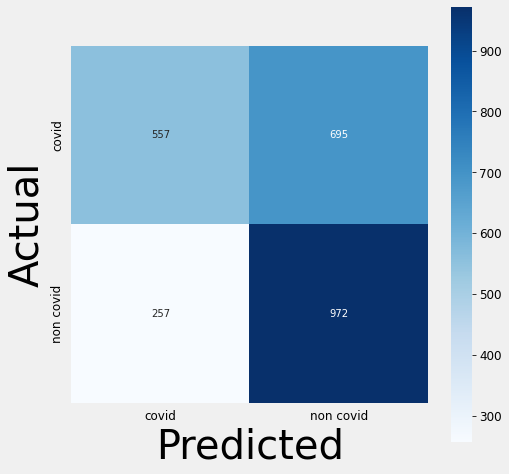

In [ ]:
cm_pca = confusion_matrix(df_pca['True Label'], df_pca['cluster pca'])
disease_types = ['covid', 'non covid']
plt.figure(figsize=(8, 8))
ax = sns.heatmap(cm_pca, cmap=plt.cm.Blues, annot=True, square=True, fmt='g', xticklabels=disease_types, yticklabels=disease_types)
ax.set_ylabel('Actual', fontsize=40)
ax.set_xlabel('Predicted', fontsize=40)

### Clustering using VGG for feature extraction and KMeans

In [ ]:
path_images = '/content/sarscov2-ctscan-dataset-clustering'

# change the working directory to the path where the images are located
os.chdir(path_images)

# this list holds all the image filename
img_filenames = []

# creates a ScandirIterator aliased as files
with os.scandir(path_images) as files:
  # loops through each file in the directory
    for file in files:
        if file.name.endswith('.png'):
          # adds only the image files to the img_filenames list
            img_filenames.append(file.name)

In [ ]:
# model definition


def extract_features_vgg(direc):
    features = []
    images_name = []
    # load the image as a 224x224 array
    model = VGG16()
    # exclude classification layer
    model = Model(inputs = model.inputs, outputs = model.layers[-2].output)
    for i in direc:
      img = tf.keras.utils.load_img(i, target_size=(224,224))
      x = tf.keras.utils.img_to_array(img)
      reshaped_img = x.reshape(1,224,224,3) 
      imgx = preprocess_input(reshaped_img)
      feat = model.predict(imgx, use_multiprocessing=True)
      features.append(feat)
      images_name.append(i)
    return features, images_name

In [ ]:

start_time_vggkmeans = time.time()
img_feat, img_name = extract_features_vgg(img_filenames)

# flatten images in order to apply the clustering algorithm
flattened_img = []
for i in img_feat:
  flattened_img.append(i.flatten())

# cluster
k = 2

clusters_vgg = KMeans(k, random_state = 13)
clusters_vgg.fit(flattened_img)
final_time_vggmeans = time.time() - start_time_vggkmeans
#print("--- %s seconds ---" % (time.time() - start_time_vggkmeans))

In [ ]:
# creating dataframe to show the results
df_vgg = pd.DataFrame(img_name, columns=['nome'])
df_vgg["cluster vgg"] = clusters_vgg.labels_
df_vgg.head(10)

,nome,cluster vgg
0,Non-Covid (520).png,0
1,Covid (370).png,1
2,Non-Covid (1153).png,0
3,Covid (845).png,1
4,Covid (858).png,1
5,Covid (156).png,1
6,Covid (729).png,1
7,Non-Covid (665).png,1
8,Non-Covid (696).png,1
9,Non-Covid (646).png,0


In [ ]:
# checking results
count_nocovid_zero, count_nocovid_uno, count_covid_zero, count_covid_uno= 0,0,0,0
len_zero, len_uno = 0,0

for index, row in df_vgg.iterrows():

    if 'Non' in row['nome'] :
      
      if row['cluster vgg'] == 0:
        count_nocovid_zero += 1
        len_zero +=1

      if row['cluster vgg'] == 1:
        count_nocovid_uno += 1
        len_uno +=1

    else:

      if row['cluster vgg'] == 0:
        count_covid_zero += 1
        len_zero +=1

      if row['cluster vgg'] == 1:
        count_covid_uno += 1
        len_uno +=1

In [ ]:
print("Results of clustering with VGG & Kmeans \n")
print("Time used for training: "+   str(datetime.timedelta(seconds = final_time_vggmeans)))

print("\n% images without covid in cluster 0: "+str(round(count_nocovid_zero/len_zero*100,2)))
print("% images with covid in cluster 0: "+str(round(count_covid_zero/len_zero*100,2)))

print("\n% images without covid in cluster 1: "+str(round(count_nocovid_uno/len_uno*100,2)))
print("% images with covid in cluster 1: "+str(round(count_covid_uno/len_uno*100,2)))

Results of clustering with VGG & Kmeans 

Time used for training: 0:02:47.041015

% images without covid in cluster 0: 40.66
% images with covid in cluster 0: 59.34

% images without covid in cluster 1: 53.0
% images with covid in cluster 1: 47.0


In [ ]:
non_covid = 0

if (count_covid_uno < count_nocovid_uno):
  non_covid = 1


In [ ]:
df_vgg["True Label"] = np.zeros(len(df_vgg), int)
df_vgg

,nome,cluster vgg,True Label
0,Non-Covid (520).png,0,0
1,Covid (370).png,1,0
2,Non-Covid (1153).png,0,0
3,Covid (845).png,1,0
4,Covid (858).png,1,0
...,...,...,...
2476,Non-Covid (527).png,0,0
2477,Covid (1020).png,1,0
2478,Non-Covid (463).png,1,0
2479,Non-Covid (535).png,1,0


In [ ]:
for i in df_vgg.index:
  if 'Non' in df_vgg.nome.loc[i]:
    df_vgg["True Label"].loc[i] = non_covid
  else:
    df_vgg["True Label"].loc[i] = 1 - non_covid


In [ ]:
df_vgg

,nome,cluster vgg,True Label
0,Non-Covid (520).png,0,1
1,Covid (370).png,1,0
2,Non-Covid (1153).png,0,1
3,Covid (845).png,1,0
4,Covid (858).png,1,0
...,...,...,...
2476,Non-Covid (527).png,0,1
2477,Covid (1020).png,1,0
2478,Non-Covid (463).png,1,1
2479,Non-Covid (535).png,1,1


In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(df_vgg['True Label'], df_vgg['cluster vgg'])


Text(0.5, 86.87999999999997, 'Predicted')

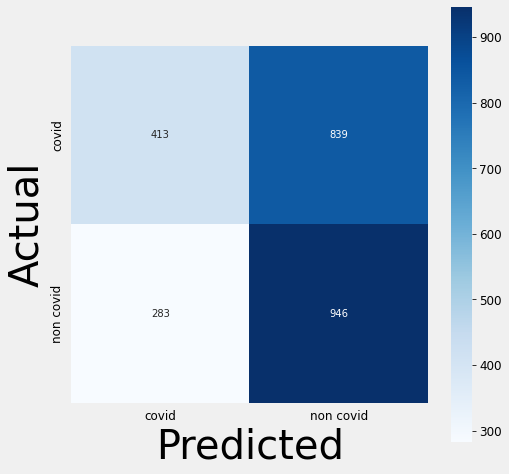

In [ ]:
import seaborn as sns
disease_types = ['covid', 'non covid']
plt.figure(figsize=(8, 8))
ax = sns.heatmap(cm, cmap=plt.cm.Blues, annot=True, square=True, fmt='g', xticklabels=disease_types, yticklabels=disease_types)
ax.set_ylabel('Actual', fontsize=40)
ax.set_xlabel('Predicted', fontsize=40)

In [ ]:
cm

array([[413, 839],
       [283, 946]])

In [ ]:
len(df_vgg[(df_vgg['True Label'] == 0) & (df_vgg['cluster vgg'] == 1)])

839

## Image similarity
Calculating image similarity using different similarity metrics.

In [ ]:
# creating dataframe using img feature calculated beforehand
df_images = pd.DataFrame(flattened_img, index=img_name)
df_images.head(5)

,0,1,2,3,4,5,6,7,8,9,...,4086,4087,4088,4089,4090,4091,4092,4093,4094,4095
Non-Covid (520).png,0.000000,0.0,1.251591,0.221018,0.418808,0.0,0.0,0.0,0.420486,0.0,...,0.0,1.693559,1.234957,0.428030,0.650480,0.0,0.127874,0.0,0.0,0.839416
Covid (370).png,0.087096,0.0,1.316731,0.278746,0.896023,0.0,0.0,0.0,0.814015,0.0,...,0.0,1.507797,1.051467,0.087073,0.461906,0.0,0.407211,0.0,0.0,1.239043
Non-Covid (1153).png,0.000000,0.0,1.260932,0.467700,0.466579,0.0,0.0,0.0,0.595809,0.0,...,0.0,1.844725,1.239521,0.351306,0.607248,0.0,0.174432,0.0,0.0,0.962228
Covid (845).png,0.143671,0.0,1.441163,0.413132,0.812411,0.0,0.0,0.0,0.538521,0.0,...,0.0,1.286106,1.013434,0.058648,0.362130,0.0,0.249883,0.0,0.0,1.297005
Covid (858).png,0.118638,0.0,1.372744,0.422497,0.878288,0.0,0.0,0.0,0.470827,0.0,...,0.0,1.479987,1.139221,0.078860,0.480750,0.0,0.260130,0.0,0.0,1.186260


### Euclidean distance

In [ ]:
# euclidean (default parameter distance_matrix p = 2)
start_euclidean = time.time()
euclidean = pd.DataFrame(distance_matrix(df_images.values, df_images.values), index=df_images.index, columns=df_images.index)
final_euclidean = time.time() - start_euclidean

In [ ]:
# printing the closest images to a given image (test)
euclidean['Covid (11).png'].nsmallest(10)

Covid (11).png      0.000000
Covid (10).png      5.044237
Covid (9).png       5.216575
Covid (7).png       5.366570
Covid (8).png       6.165296
Covid (5).png       6.667800
Covid (6).png       7.002062
Covid (512).png     7.189174
Covid (3).png       7.402007
Covid (1133).png    7.442588
Name: Covid (11).png, dtype: float64

### Cosine distance

In [ ]:
start_cosine_time = time.time()
result=np.zeros((len(flattened_img), len(flattened_img)))
for i in range(len(flattened_img)):
  for j in range(len(flattened_img)):
    result[i][j] = distance.cosine(flattened_img[i], flattened_img[j])

cosine_df = pd.DataFrame(result, columns = img_name, index = img_name)
final_cosine = time.time()-start_cosine_time

In [ ]:
# printing the closest images to a given image (test)
cosine_df['Covid (11).png'].nsmallest(10)

Covid (11).png      0.000000
Covid (10).png      0.004940
Covid (9).png       0.005364
Covid (7).png       0.005493
Covid (8).png       0.007494
Covid (5).png       0.008669
Covid (6).png       0.009668
Covid (512).png     0.010188
Covid (3).png       0.010732
Covid (1133).png    0.010946
Name: Covid (11).png, dtype: float64

## Summary

In [ ]:
rows = ['Classification with CNN', 'Clustering with PCA - KMeans', 'Clustering with VGG - KMeans', 'Image similarity - Euclidean', 'Image similarity - Cosine']

column = ['Computational time']


In [ ]:
computational_times = [str(datetime.timedelta(seconds = end_cnn_time)), str(datetime.timedelta(seconds = end_pca_k)),
                           str(datetime.timedelta(seconds = final_time_vggmeans)), str(datetime.timedelta(seconds = final_euclidean)), str(datetime.timedelta(seconds = final_cosine))]
computational_times

['0:00:51.511646',
 '0:03:44.233703',
 '0:02:47.041015',
 '0:02:27.878073',
 '0:05:23.911404']

In [ ]:
df_summary = pd.DataFrame(computational_times, columns = column, index = rows)
df_summary

,Computational time
Classification with CNN,0:00:51.511646
Clustering with PCA - KMeans,0:03:44.233703
Clustering with VGG - KMeans,0:02:47.041015
Image similarity - Euclidean,0:02:27.878073
Image similarity - Cosine,0:05:23.911404


In [ ]:
def has_covid(stringa):
  if 'Non' in stringa:
    return 0
  return 1


def precision_score(image, retrieved):
  result = 0
  for i in retrieved.keys():
    if has_covid(i) == has_covid(image):
      result += 1
  return result/len(retrieved)

def funct_precision(x, df_metric, img_names):
  avg_precision = {}
  for i in img_names:
    res = df_metric[i].nsmallest(x+1)[1:]
    avg_precision[i] = precision_score(i, res)
  return sum(avg_precision.values())/len(avg_precision)

def recall_score(image, retrieved, tot_pos, tot_neg):
  result = 0
  for i in retrieved.keys():
    if has_covid(i) == has_covid(image):
      result += 1
  return result/tot_pos if has_covid(image) else result/tot_neg

def count_(img_names):
  count_pos, count_neg = 0,0
  for i in img_names:
    if has_covid(i):
      count_pos += 1
    else:
      count_neg += 1
  return count_pos, count_neg

def funct_recall(x, df_metric, img_names):
  avg_recall = {}
  for i in img_names:
    res = df_metric[i].nsmallest(x+1)[1:]
    tot_pos, tot_neg = count_(img_name)
    avg_recall[i] = recall_score(i, res, tot_pos, tot_neg)
  return sum(avg_recall.values())/len(avg_recall)


In [ ]:
#@title Queries { run: "auto" }
#inizialize 


#@markdown Estrai le *n* immagini più simili dell'immagine indicata e secondo la metrica { run: "auto" }
numero_immagini = 11 #@param {type:"integer"}
numero_immagini +=1
metrica = "euclidean" #@param ["euclidean", "cosine"]
file_name = "Covid (17).png" #@param {type:"string"}

if len(file_name.strip())!=0:
  if metrica == "euclidean":
    res = euclidean[file_name].nsmallest(numero_immagini)[1:]
  else:
    res = cosine_df[file_name].nsmallest(numero_immagini)[1:]

res = dict(res)
print(f"Le {numero_immagini-1} immagini più simili sono")
for key,value in res.items():
	print(key, ':', round(value,3))
 
print(f"Precision: {precision_score(file_name, res)}")

Le 11 immagini più simili sono
Covid (16).png : 3.56
Covid (18).png : 4.205
Covid (15).png : 4.701
Covid (20).png : 5.809
Covid (12).png : 5.84
Covid (14).png : 5.948
Non-Covid (351).png : 5.983
Covid (19).png : 6.024
Covid (660).png : 6.036
Non-Covid (203).png : 6.055
Non-Covid (201).png : 6.059
Precision: 0.7272727272727273


In [ ]:
X = np.array(range(1, 2481, 100))
#print(X)
Y_precision = np.array([funct_precision(i, euclidean, img_name) for i in X])


Precision plot averaged over all images.

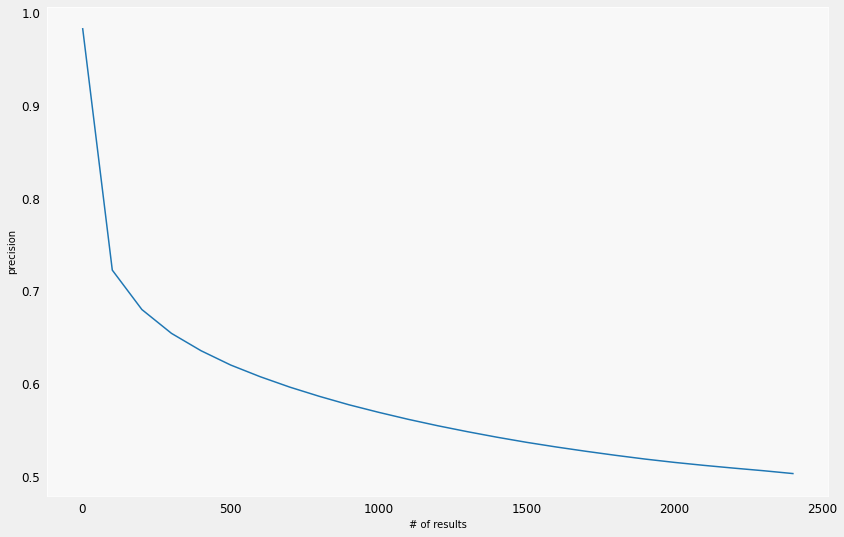

In [ ]:
plt.plot(X, Y_precision)
plt.xlabel("# of results")
plt.ylabel("precision")
plt.show()

In [ ]:
Y_recall = np.array([funct_recall(i, euclidean, img_name) for i in X])

Precision-recall curve averaged over all images.

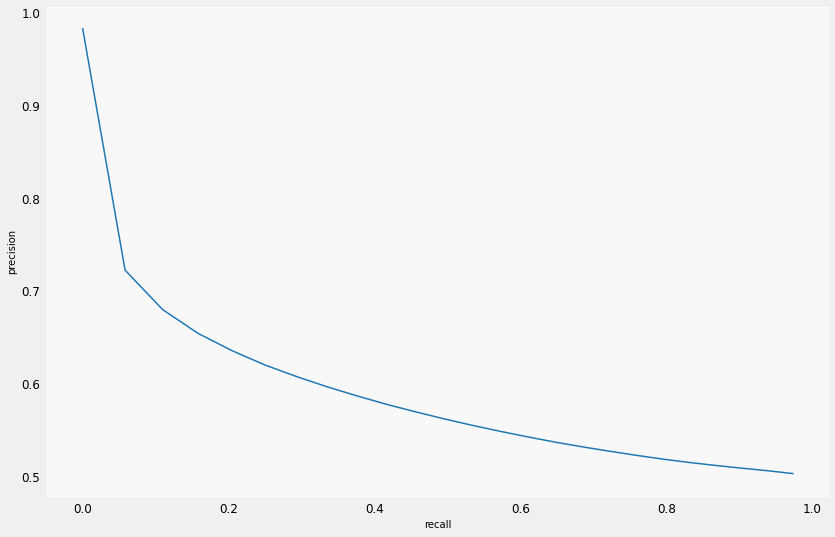

In [ ]:
plt.plot(Y_recall, Y_precision)
plt.xlabel("recall")
plt.ylabel("precision")
plt.show()

In [ ]:
#@title Queries clustering { run: "auto" }

#@markdown Estrai *n* immagini del cluster di appartenenza dell'immagine data

numero_immagini = 10 #@param {type:"integer"}
file_name = "Non-Covid (18).png" #@param {type:"string"}
method = "PCA" #@param ["PCA", "VGG"]

if method == "VGG":
  cluster = df_vgg[df_vgg['nome'] == file_name].iloc[0]['cluster vgg']
  print(f"Il cluster assegnato all'immagine è il cluster {cluster}. Le prime {numero_immagini} immagini di quel cluster sono: \n")
  print(df_vgg.loc[df_vgg['cluster vgg'] == cluster][:numero_immagini])

else:
  cluster = df_pca[df_pca['nome'] == file_name].iloc[0]['cluster pca']
  print(f"Il cluster assegnato all'immagine è il cluster {cluster}. Le prime {numero_immagini} immagini di quel cluster sono: \n")
  print(df_pca.loc[df_pca['cluster pca'] == cluster][:numero_immagini])


Il cluster assegnato all'immagine è il cluster 1. Le prime 10 immagini di quel cluster sono: 

                   nome  cluster pca  True Label
1       Covid (370).png            1           0
3       Covid (845).png            1           0
4       Covid (858).png            1           0
5       Covid (156).png            1           0
6       Covid (729).png            1           0
7   Non-Covid (665).png            1           1
8   Non-Covid (696).png            1           1
9   Non-Covid (646).png            1           1
10   Non-Covid (36).png            1           1
11  Non-Covid (446).png            1           1


# DeepLesion dataset

In [ ]:
# download dataset
%%capture
os.chdir('/content')
!kaggle datasets download -d matteolimoncini/deeplesion-smallimages
!unzip deeplesion-smallimages.zip -d deeplesion-smallimages
!rm deeplesion-smallimages.zip

# load dataset
metadata = pd.read_csv('/content/deeplesion-smallimages/DL_info.csv', sep = ',')

# of results: 7
3


,File_name,Patient_index,Study_index,Series_ID,Key_slice_index,Measurement_coordinates,Bounding_boxes,Lesion_diameters_Pixel_,Normalized_lesion_location,Coarse_lesion_type,Possibly_noisy,Slice_range,Spacing_mm_px_,Image_size,DICOM_windows,Patient_gender,Patient_age,Train_Val_Test
4066,000355_01_01_012.png,355,1,1,12,"256.889, 272.889, 264.889, 268.444, 262.222, 2...","251.889, 261.667, 269.889, 278.778","9.15167, 7.5947","0.499657, 0.387693, 0.433845",-1,0,"4, 18","0.494141, 0.494141, 5","512, 512","-175, 275",M,2.0,1
4067,000355_01_01_010.png,355,1,1,10,"258.667, 262.222, 240.889, 275.556, 248, 279.1...","235.889, 257.222, 263.667, 284.111","22.2222, 13.5683","0.477991, 0.376288, 0.431413",-1,0,"4, 18","0.494141, 0.494141, 5","512, 512","-175, 275",M,2.0,1
4068,000355_02_01_011.png,355,2,1,11,"242.667, 246.222, 214.222, 272, 228.444, 274.6...","204.778, 241.222, 247.667, 279.667","38.3872, 31.1111","0.432059, 0.406616, 0.430374",-1,0,"5, 20","0.425781, 0.425781, 5","512, 512","-175, 275",M,2.0,1
4069,000355_02_01_014.png,355,2,1,14,"261.333, 265.778, 231.111, 278.222, 246.222, 2...","226.111, 255.444, 266.333, 287.667","32.6841, 23.9341","0.471058, 0.445111, 0.452038",-1,0,"5, 20","0.425781, 0.425781, 5","512, 512","-175, 275",M,2.0,1
4070,000355_02_02_081.png,355,2,2,81,"171.255, 195.972, 136.828, 149.186, 133.297, 1...","128.297, 144.186, 176.255, 200.972","58.0879, 43.435","0.29259, 0.269188, 0.478483",-1,0,"51, 111","0.425781, 0.425781, 1","512, 512","-1500, 500",M,2.0,1
17465,001852_01_01_052.png,1852,1,1,52,"163.546, 216.89, 164.095, 201.526, 157.785, 21...","152.785, 196.526, 177.051, 221.89","15.3736, 14.277","0.314418, 0.25201, 0.60302",4,0,"22, 82","0.546875, 0.546875, 1","512, 512","-175, 275",M,2.0,3
32162,004282_01_01_041.png,4282,1,1,41,"352.335, 259.396, 302.804, 228.439, 340.091, 2...","297.804, 215.439, 357.335, 269.961","58.4086, 52.5021","0.629681, 0.413575, 0.628557",2,0,"26, 56","0.464844, 0.464844, 2","512, 512","-175, 275",M,2.0,3


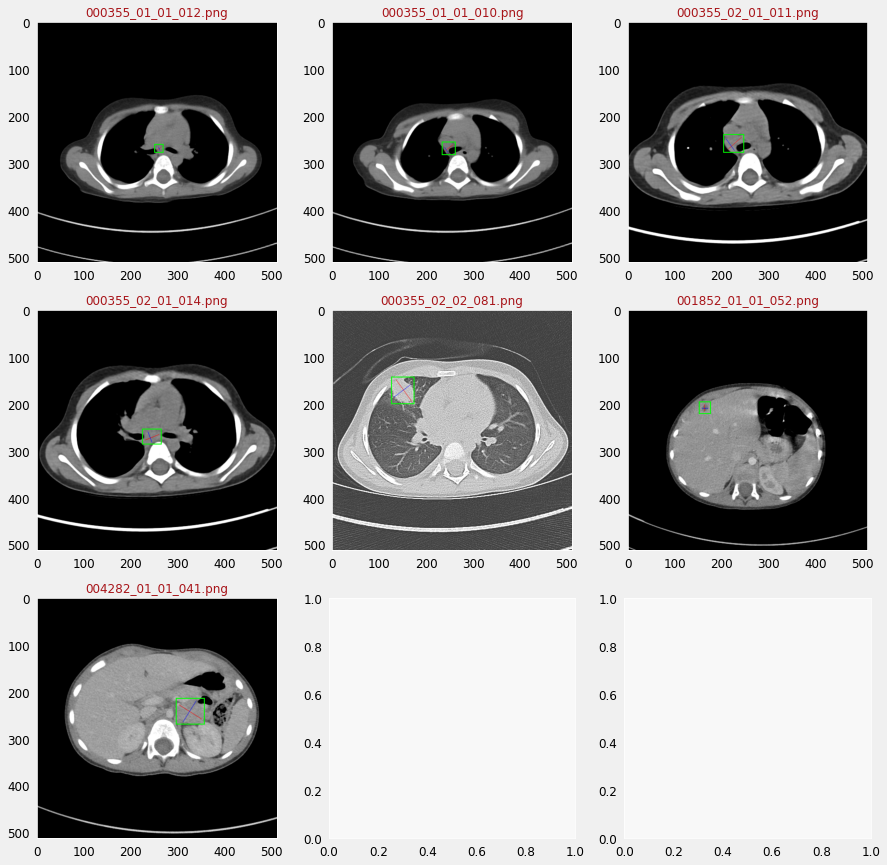

In [ ]:
#@title query on csv { run: "auto" }
#inizialize 
res = metadata

#@markdown quali pazienti hanno età compresa tra x e y { run: "auto" }
età_x = 1 #@param {type:"integer"}
età_y = 3 #@param {type:"integer"}
if età_x is not None:
  res = res[(res['Patient_age'] > età_x)]
if età_y is not None:
  res = res[res['Patient_age'] < età_y]

#@markdown filtra i pazienti in base al sesso M/F { run: "auto" }
gender = "M" #@param ["M", "F", ""]
if len(gender)!=0:
  res = res[(res['Patient_gender'] == gender)]

#@markdown filtra i pazienti in base al patient index { run: "auto" }
patient_index = None #@param {type:"integer"}
if patient_index is not None:
  res = res[(res['Patient_index'] == patient_index)]

#@markdown filtra i pazienti in base allo study index { run: "auto" }
study_index = None #@param {type:"integer"}
if study_index is not None:
  res = res[(res['Study_index'] == study_index)]

#@markdown filtra i pazienti in base al filename { run: "auto" }
file_name = "" #@param {type:"string"}
if len(file_name.strip())!=0:
  res = res[(res['File_name'] == file_name.strip())]

#@markdown remove possibly noisy { run: "auto" }
remove_noisy = False #@param {type:"boolean"}
if remove_noisy:
  res = res[(res['Possibly_noisy'] == 0)]


print("# of results: " + str(len(res)))

res = res[:12]
files = []

# create the figure

NROWS = int(len(res)/3) if len(res)%3 == 0 else int((len(res))/3)+1
print(NROWS)
fig, axs = plt.subplots(nrows=NROWS, ncols=3, figsize=(15, 15))
# flatten the axis into a 1-d array to make it easier to access each axes
axs = axs.flatten()
for i, img_name in enumerate(res['File_name']):
  content_images = '/content/deeplesion-smallimages/Key_slices/Key_slices/'+img_name
  pic = plt.imread(content_images)
  axs[i].imshow(pic)
  axs[i].set(title=img_name)

res